# RBFN Example

### Import all necessary packages

In [29]:
import os
import numpy as np
import pandas as pd
import copy
import keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import time

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from keras import backend as K
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Constant
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras import metrics, optimizers
import matplotlib.pyplot as plt

from matplotlib import pyplot
from matplotlib import cm

## Define RBF Layer

In [46]:
""" Code borrowed from https://github.com/PetraVidnerova/rbf_keras
     Credit to user PetraVidnerova
"""

class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Import Saddlepoint Data

In [3]:
TrainingSet = pd.read_csv('CSCE823_HW2_regression_non_testdata.csv')
TestSet = pd.read_csv('CSCE823_HW2_regression_testdata.csv')
TrainingSet = TrainingSet.values
TestSet = TestSet.values
np.random.shuffle(TrainingSet)
np.random.shuffle(TestSet)
X_train = TrainingSet[:,0:2]
y_train = TrainingSet[:,2]
X_test = TestSet[:,0:2]
y_test = TestSet[:,2]

### Build Function for Z Calculation

In [4]:
def computeZ(x1,x2):
    
    z = x1**2-x2**2
    
    return z

### Build Function for 3D Surface Plot

In [5]:
def build3DSurface(Xdata, ydata):
    x = Xdata[:,0]
    y = Xdata[:,1]
    z = computeZ(x,y)
    zdata = ydata
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)
    ax.scatter3D(x, y, zdata, c=zdata, cmap='Greens')
    plt.title('Raw Errors on Saddle Surface')
    plt.ylabel('x2')
    plt.xlabel('x1')

### Raw Errors of Training Data

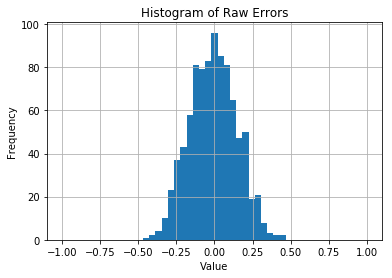

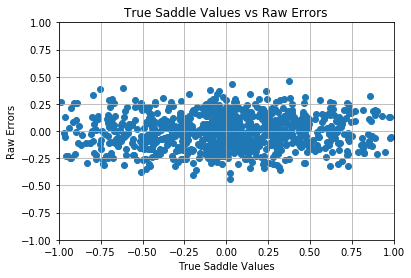

In [6]:
errors = np.zeros(len(X_train))
errors = computeZ(X_train[:,0], X_train[:,1]) - y_train
bins = np.linspace(-1,1,50)

plt.figure(3)
plt.hist(errors, bins)
plt.title('Histogram of Raw Errors')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.grid(True)

plt.figure(4)
plt.scatter(computeZ(X_train[:,0], X_train[:,1]), errors)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title('True Saddle Values vs Raw Errors')
plt.xlabel('True Saddle Values')
plt.ylabel('Raw Errors')
plt.grid(True)

### Report Metrics on Error

In [7]:
mse = np.dot(errors, errors.T)/len(errors)
rmse = np.sqrt(mse)
mae = np.sum(np.absolute(errors))/len(errors)
print("The MSE = " + str(mse))
print("The RMSE = " + str(rmse))
print("The MAE = " + str(mae))

The MSE = 0.023635225000437004
The RMSE = 0.15373751982010445
The MAE = 0.124651957997872


### Prepare Data for Training/Validation

In [8]:
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, train_size = 0.75, random_state=1)

C:\Users\infer\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Build Basic MLP Network

In [9]:
def ANNmodel(layers, nodes, learningRate, activationFunc, opt):
    
    model = Sequential()
    model.add(Dense(nodes, input_dim = 2)) # Input Layer
    
    for i in range(0,layers): # Create hidden layers
        model.add(Dense(nodes, activation = activationFunc))
        
    model.add(Dense(1, activation = 'tanh')) # Output layer

    engine = opt(lr=learningRate)
    model.compile(optimizer=engine, loss='mean_squared_error', metrics=[metrics.mse, metrics.mae])
    
    return model

### Build RBF Network

In [47]:
def RBFmodel(X, input_shape, betas, nodePercent, learningRate, opt):

    """
    X - data to feed in
    input_shape - number of features, use the format (n,)
    betas - float number
    nodePercent - number between 0-1 to decide how many prototypes to use from the number of observations
    learningRate - learning rate
    opt - which optimizer to use

    """

    model = Sequential()
    rbflayer = RBFLayer((np.round((X.shape[0]*nodePercent),0).astype(int)),
                            initializer=InitCentersRandom(X),
                            betas=betas,
                            input_shape=input_shape)
    model.add(rbflayer)
    model.add(Dense(1))
    
    engine = opt(lr = learningRate)
    model.compile(loss='mean_squared_error',
                    optimizer=engine, metrics=[metrics.mse, metrics.mae])
    
    return model

### Define the two networks

In [52]:
MLPmodel = ANNmodel(1, 20, 0.09, 'tanh', optimizers.SGD)
RBFNmodel = RBFmodel(X_trn, (2,), 1, 0.03, 0.09, optimizers.SGD)

### Train and validate RBFN

elasped time 4.981861114501953


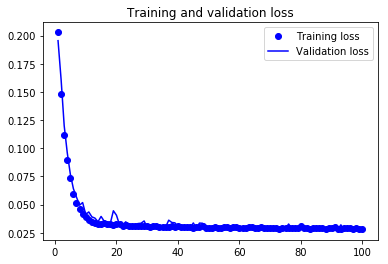

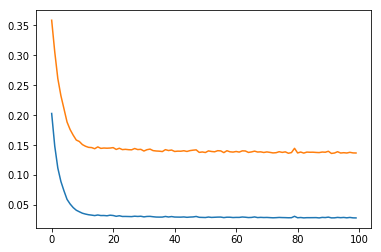

In [49]:
startTime = time.time()
history = RBFNmodel.fit(X_trn, y_trn, validation_data=(X_val,y_val), epochs=100, batch_size=50, verbose = 0, callbacks = None)
endTime = time.time()-startTime
print("elasped time " + str(endTime))

loss = history.history['loss']
val_loss = history.history['val_loss']
epochsR = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochsR, loss, 'bo', label='Training loss')
plt.plot(epochsR, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.figure(5)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])

### Fully Train both Networks

#### MLP Network

elasped time 5.499002695083618
MSE - 0.02639253654827674


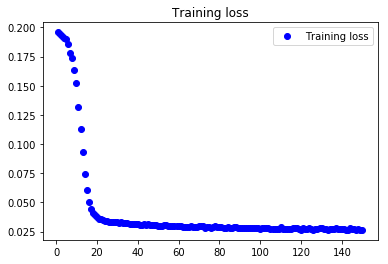

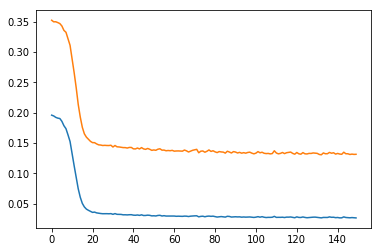

In [59]:
startTime = time.time()
MLPhistory = MLPmodel.fit(X_train, y_train, epochs=150, batch_size=50, verbose = 0, callbacks = None)
endTime = time.time()-startTime
print("elasped time " + str(endTime))
print("MSE - " + str((MLPhistory.history['mean_squared_error'])[-1]))

lossM = MLPhistory.history['loss']
MepochsR = range(1, len(lossM) + 1)

plt.figure()
plt.plot(MepochsR, lossM, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(MLPhistory.history['mean_squared_error'])
plt.plot(MLPhistory.history['mean_absolute_error'])

#### Prediction Errors

The MSE = 0.003052240598130125
The RMSE = 0.05524708678410225
The MAE = 0.04073976163675157


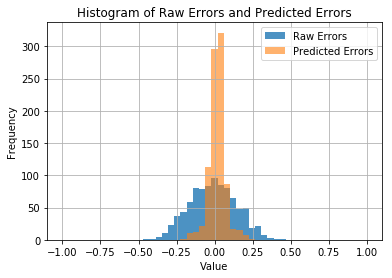

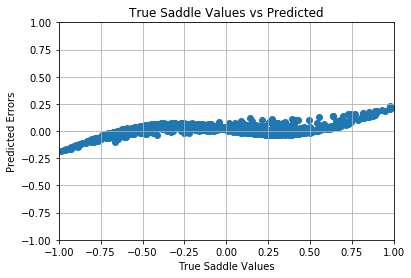

In [60]:
y = MLPmodel.predict(X_train, batch_size = 50)
yTrue = computeZ(X_train[:,0], X_train[:,1])
NewErrorMLP = yTrue - y[:,0]

plt.figure()
plt.hist(errors, bins, alpha = 0.8, label = 'Raw Errors')
plt.hist(NewErrorMLP, bins, alpha = 0.6, label = 'Predicted Errors')
plt.title('Histogram of Raw Errors and Predicted Errors')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.legend()
plt.grid(True)

plt.figure()
plt.scatter(computeZ(X_train[:,0], X_train[:,1]), NewErrorMLP)
plt.title('True Saddle Values vs Predicted')
plt.xlabel('True Saddle Values')
plt.ylabel('Predicted Errors')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid(True)

mse = np.dot(NewErrorMLP, NewErrorMLP.T)/len(NewErrorMLP)
rmse = np.sqrt(mse)
mae = np.sum(np.absolute(NewErrorMLP))/len(NewErrorMLP)
print("The MSE = " + str(mse))
print("The RMSE = " + str(rmse))
print("The MAE = " + str(mae))

#### RBF Network

elasped time 7.657867431640625
MSE - 0.027994675354825124


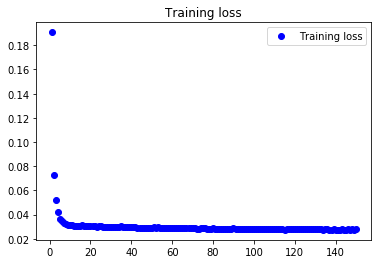

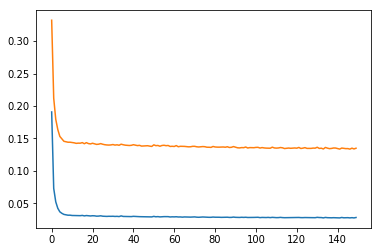

In [53]:
startTime = time.time()
RBFhistory = RBFNmodel.fit(X_train, y_train, epochs=150, batch_size=50, verbose = 0, callbacks = None)
endTime = time.time()-startTime
print("elasped time " + str(endTime))
print("MSE - " + str((RBFhistory.history['mean_squared_error'])[-1]))

lossR = RBFhistory.history['loss']
RepochsR = range(1, len(lossR) + 1)

plt.figure()
plt.plot(RepochsR, lossR, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(RBFhistory.history['mean_squared_error'])
plt.plot(RBFhistory.history['mean_absolute_error'])

#### Prediction Errors

The MSE = 0.004723042707398658
The RMSE = 0.06872439674088568
The MAE = 0.054488363886478736


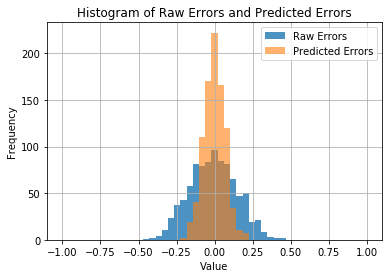

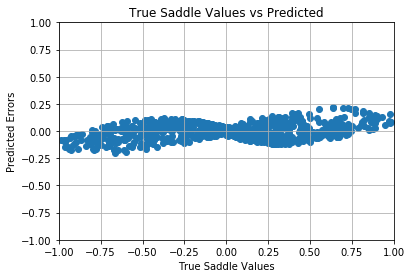

In [54]:
y = RBFNmodel.predict(X_train, batch_size = 50)
yTrue = computeZ(X_train[:,0], X_train[:,1])
NewErrorRBF = yTrue - y[:,0]

plt.figure()
plt.hist(errors, bins, alpha = 0.8, label = 'Raw Errors')
plt.hist(NewErrorRBF, bins, alpha = 0.6, label = 'Predicted Errors')
plt.title('Histogram of Raw Errors and Predicted Errors')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.legend()
plt.grid(True)

plt.figure()
plt.scatter(computeZ(X_train[:,0], X_train[:,1]), NewErrorRBF)
plt.title('True Saddle Values vs Predicted')
plt.xlabel('True Saddle Values')
plt.ylabel('Predicted Errors')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid(True)

mse = np.dot(NewErrorRBF, NewErrorRBF.T)/len(NewErrorRBF)
rmse = np.sqrt(mse)
mae = np.sum(np.absolute(NewErrorRBF))/len(NewErrorRBF)
print("The MSE = " + str(mse))
print("The RMSE = " + str(rmse))
print("The MAE = " + str(mae))

### Evaluate on Test Set

### MLP

2500/2500 [==============================] - 0s 15us/step
[0.003186325724236667, 0.003186325724236667, 0.04186519585549831]


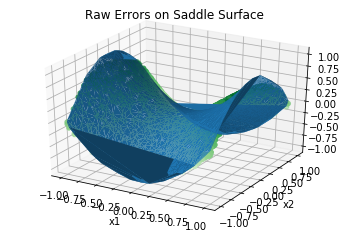

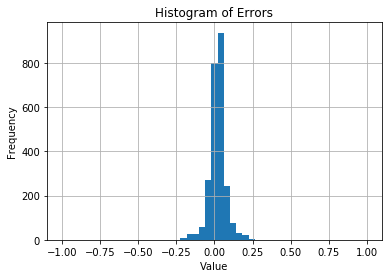

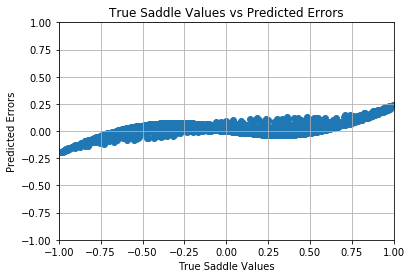

The MSE = 0.0031863256759862117
The RMSE = 0.05644754800685511
The MAE = 0.04186519540242095


In [61]:
scores = MLPmodel.evaluate(X_test, y_test, batch_size = 50)
print(scores)
y = MLPmodel.predict(X_test, batch_size = 50)

build3DSurface(X_test, y[:,0])
plt.show()

yTrue = computeZ(X_test[:,0], X_test[:,1])
TestError = np.zeros(len(X_test))
TestError = yTrue - y[:,0]

plt.hist(TestError, bins)
plt.title('Histogram of Errors')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.grid(True)
plt.show()

plt.scatter(yTrue, TestError)
plt.title('True Saddle Values vs Predicted Errors')
plt.xlabel('True Saddle Values')
plt.ylabel('Predicted Errors')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid(True)
plt.show()

mse = np.dot(TestError, TestError.T)/len(TestError)
rmse = np.sqrt(mse)
mae = np.sum(np.absolute(TestError))/len(TestError)
print("The MSE = " + str(mse))
print("The RMSE = " + str(rmse))
print("The MAE = " + str(mae))

#### RBFN

2500/2500 [==============================] - 0s 17us/step
[0.004814310446381569, 0.004814310446381569, 0.0552245070040226]


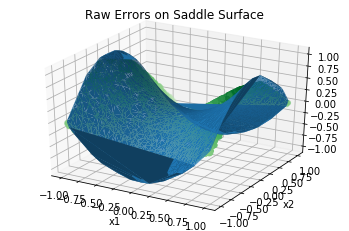

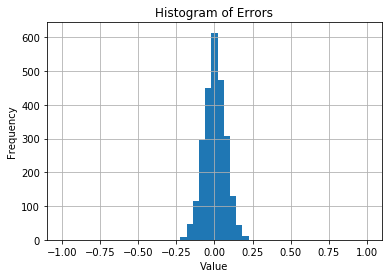

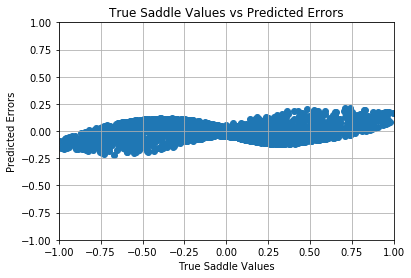

The MSE = 0.00481431053954784
The RMSE = 0.06938523286368534
The MAE = 0.055224506361836664


In [57]:
scores = RBFNmodel.evaluate(X_test, y_test, batch_size = 50)
print(scores)
y = RBFNmodel.predict(X_test, batch_size = 50)

build3DSurface(X_test, y[:,0])
plt.show()

yTrue = computeZ(X_test[:,0], X_test[:,1])
TestError = np.zeros(len(X_test))
TestError = yTrue - y[:,0]

plt.hist(TestError, bins)
plt.title('Histogram of Errors')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.grid(True)
plt.show()

plt.scatter(yTrue, TestError)
plt.title('True Saddle Values vs Predicted Errors')
plt.xlabel('True Saddle Values')
plt.ylabel('Predicted Errors')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid(True)
plt.show()

mse = np.dot(TestError, TestError.T)/len(TestError)
rmse = np.sqrt(mse)
mae = np.sum(np.absolute(TestError))/len(TestError)
print("The MSE = " + str(mse))
print("The RMSE = " + str(rmse))
print("The MAE = " + str(mae))